#Feature Engineering

In [1]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##Load celtra data (10% random subsample of the large data)

In [25]:
data = graphlab.SFrame.read_csv('E:\celtraMiningFrik\ccdm_mine.csv',column_type_hints=str);

Read 69661 lines. Lines per second: 52334.3

Finished parsing file E:\celtraMiningFrik\ccdm_mine.csv

Parsing completed. Parsed 245377 lines in 3.70821 secs.

##### Convert numeric types from string to int/float

In [30]:
data['ADLOADINGTIME']=data['ADLOADINGTIME'].astype(float)
data['GEOIP_LAT'] = data['GEOIP_LAT'].apply(lambda x: 0 if x=='null' else x)
data['GEOIP_LAT']=data['GEOIP_LAT'].astype(float)
data['GEOIP_LNG'] = data['GEOIP_LNG'].apply(lambda x: 0 if x=='null' else x)
data['GEOIP_LNG']=data['GEOIP_LNG'].astype(float)
data['TIMESTAMP']=data['TIMESTAMP'].astype(int)
data['HOSTWINDOWHEIGHT'] = data['HOSTWINDOWHEIGHT'].apply(lambda x: 0 if x=='null' else x)
data['HOSTWINDOWHEIGHT']=data['HOSTWINDOWHEIGHT'].astype(int)
data['HOSTWINDOWWIDTH'] = data['HOSTWINDOWWIDTH'].apply(lambda x: 0 if x=='null' else x)
data['HOSTWINDOWWIDTH']=data['HOSTWINDOWWIDTH'].astype(int)
data['TOPMOSTREACHABLEWINDOWHEIGHT'] = data['TOPMOSTREACHABLEWINDOWHEIGHT'].apply(lambda x: 0 if x=='null' else x)
data['TOPMOSTREACHABLEWINDOWHEIGHT']=data['TOPMOSTREACHABLEWINDOWHEIGHT'].astype(int)
data['TOPMOSTREACHABLEWINDOWWIDTH'] = data['TOPMOSTREACHABLEWINDOWWIDTH'].apply(lambda x: 0 if x=='null' else x)
data['TOPMOSTREACHABLEWINDOWWIDTH']=data['TOPMOSTREACHABLEWINDOWWIDTH'].astype(int)

#####remove EXTERNALCREATIVEID as it is always null

In [31]:
data.remove_column('EXTERNALCREATIVEID');

#####remove NETWORKTYPE as it is mainly null

In [32]:
data.remove_column('NETWORKTYPE');

remove top 5% of ADLOADINGTIME outliers

In [33]:
# 3.7835
perct = 95
print(np.percentile(data['ADLOADINGTIME'],perct))
data = data[data['ADLOADINGTIME']<np.percentile(data['ADLOADINGTIME'],perct)]
print(graphlab.evaluation.rmse(data['ADLOADINGTIME'], graphlab.SArray.from_const(data['ADLOADINGTIME'].mean(),len(data['ADLOADINGTIME']))))

18.7192
3.69722294021


#####show data

In [5]:
data.show()

Canvas is accessible via web browser at the URL: http://localhost:31720/index.html
Opening Canvas in default web browser.


##Feature engineering

combine TOPMOSTREACHABLEWINDOWHEIGHT and TOPMOSTREACHABLEWINDOWWIDTH by multiplication and computation of the ratio

remove data with very large or negative data

In [48]:
data['TOPMOSTREACHABLEWINDOWAREA'] = data['TOPMOSTREACHABLEWINDOWWIDTH']*data['TOPMOSTREACHABLEWINDOWHEIGHT'];
data = data[data['TOPMOSTREACHABLEWINDOWAREA']>=0]
data = data[data['TOPMOSTREACHABLEWINDOWAREA']<1e7]

In [8]:
tmp = data[data['TOPMOSTREACHABLEWINDOWAREA']>1e7]
print(tmp.num_rows())

0


remove all other scree size data except the area

In [49]:
data.remove_column('TOPMOSTREACHABLEWINDOWWIDTH');
data.remove_column('TOPMOSTREACHABLEWINDOWHEIGHT');
data.remove_column('HOSTWINDOWWIDTH');
data.remove_column('HOSTWINDOWHEIGHT');

remove device orientation as it should not affect loading time

In [34]:
data.remove_column('DEVICEORIENTATION');

UA_MOBILEDEVICE can be assesed from PLATFORM -> remove

In [35]:
data.remove_column('UA_MOBILEDEVICE');

In [46]:
data = data[data['TIMESTAMP']>1458500000]
data = data[data['TIMESTAMP']<1461000000]

In [13]:
tmp = data[data['TIMESTAMP']<=1458500000]
print(tmp.num_rows())

0


GEOIP: to start combine COUNTRY with REGION for USA
In my expectation the data is to scarce to have enough entries for exact geolocation and time assignment
-> remove DMACODE, METROCODE, TIMEZONE, CITY, AREACODE

In [36]:
data.remove_column('GEOIP_TIMEZONE');
data.remove_column('GEOIP_METROCODE');
data.remove_column('GEOIP_AREACODE');
data.remove_column('GEOIP_CITY');
data.remove_column('GEOIP_DMACODE');

In [37]:
data['GEOIP_COUNTRY'] = data['GEOIP_COUNTRY'] + '_' + data['GEOIP_REGION'] 
data['GEOIP_COUNTRY'] = data['GEOIP_COUNTRY'].apply(lambda x: x if 'United States' in x.split('_')[0] else x.split('_')[0])
data.remove_column('GEOIP_REGION');

In [101]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
#LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_COUNTRY'],validation_set=test_data, max_iterations=100,verbose=False)
#model = LR_model
#rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
#print("{}: {:.4f}".format('COMBINEDID and GEOIP_COUNTRY',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LAT'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and GEOIP_LAT',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LNG'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and GEOIP_LNG',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LNG', 'GEOIP_LAT'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and GEOIP_LNG and GEOIP_LAT',rms))
#LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'GEOIP_LNG', 'GEOIP_LAT','GEOIP_COUNTRY'],validation_set=test_data, max_iterations=100,verbose=False)
#model = LR_model
#rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
#print("{}: {:.4f}".format('COMBINEDID and GEOIP_LNG and GEOIP_LAT and GEOIP_COUNTRY',rms))

COMBINEDID: 3.4685
COMBINEDID and GEOIP_LAT: 3.4681
COMBINEDID and GEOIP_LNG: 3.4684
COMBINEDID and GEOIP_LNG and GEOIP_LAT: 3.4680


In [102]:
data.remove_columns(['GEOIP_LNG','GEOIP_LAT']);
data.remove_columns(['GEOIP_COUNTRY']);

KeyError: 'Cannot find column GEOIP_COUNTRY'

 **CONCLUSIONS**

GEOIP_DATA just barely results in a reduction of RMSE -> not needed

In [38]:
data['ERRORSJSON'] = data['ERRORSJSON'].apply(lambda x: x.replace('"',''))

crate new feature by extracting sizes of images from FILESJSON

In [39]:
def extractImageSize(sIn):
    sIn = sIn.replace('[','')
    sIn = sIn.replace('}','')
    sIn = sIn.replace(']','')
    sIn = sIn.replace('{"type":"image","size":','')
    numberList = [int(s) for s in sIn.split(',') if s.isdigit()]
    if len(numberList) == 0:
        numberList = 0
    return np.sum(numberList)

data['FILESJSON_SIZE'] = data['FILESJSON'].apply(extractImageSize)

remove outliers from FILESJSON_SIZE

In [42]:
#tmp = data[data['FILESJSON_SIZE']>np.percentile(data['FILESJSON_SIZE'],99)]
#print(np.percentile(data['FILESJSON_SIZE'],99))
#print(tmp.num_rows())
data = data[data['FILESJSON_SIZE']<np.percentile(data['FILESJSON_SIZE'],99)]

The new feature is not very helpful

In [43]:
data.remove_column('FILESJSON_SIZE');

**CONCLUSIONS**

FILESJSON_SIZE is useful to remove some outliers but not as a features -> remove after removal of outliers

#####Create new fetures by combining IDS

In [44]:
data['COMBINEDID'] = data['SDK']+'_'+data['ACCOUNTID']+'_'+data['CAMPAIGNID']+'_'+data['CREATIVEID']+'_'+data['EXTERNALADSERVER']
data['COMBINEDIDWITHPLACEMENTID'] = data['SDK']+'_'+data['ACCOUNTID']+'_'+data['CAMPAIGNID']+'_'+data['CREATIVEID']+'_'+data['EXTERNALADSERVER']+'_'+data['PLACEMENTID']
data['COMBINEDEXTERNALID'] = data['EXTERNALPLACEMENTID']+'_'+data['EXTERNALSITEID']+'_'+data['EXTERNALSUPPLIERID']
data['COMBINEDEXTERNALID'] = data['COMBINEDEXTERNALID'].apply(lambda x : 'null' if x == 'null_null' or x== 'null_null_null' else x)

test with simple linear regression

In [50]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'PLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDIDWITHPLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDIDWITHPLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['CREATIVEID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('CREATIVEID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['CREATIVEID', 'PLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('CREATIVEID and PLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLACEMENTID',rms))

COMBINEDID: 3.4685
COMBINEDID and PLACEMENTID: 3.4629
COMBINEDIDWITHPLACEMENTID: 3.4630
CREATIVEID: 3.4818
CREATIVEID and PLACEMENTID: 3.4705
PLACEMENTID: 3.4748


**CONCLUSIONS**

use COMBINEDID and PLACEMENTID as separate features

In [237]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['EXTERNALPLACEMENTID', 'EXTERNALSITEID', 'EXTERNALSUPPLIERID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('EXTERNALPLACEMENTID and EXTERNALSITEID and EXTERNALSUPPLIERID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDIDWITHPLACEMENTID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDIDWITHPLACEMENTID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDEXTERNALID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDIDWITHPLACEMENTID', 'COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDIDWITHPLACEMENTID and COMBINEDEXTERNALID',rms))

COMBINEDID: 3.4685
EXTERNALPLACEMENTID and EXTERNALSITEID and EXTERNALSUPPLIERID: 3.5237
COMBINEDIDWITHPLACEMENTID: 3.4630
COMBINEDEXTERNALID: 3.5291
COMBINEDIDWITHPLACEMENTID and COMBINEDEXTERNALID2: 3.4659
COMBINEDEXTERNALID2: 3.5291


**CONCLUSIONS**

do not use any of the following external features: EXTERNALPLACEMENTID, EXTERNALSITEID, EXTERNALSUPPLIERID

######Remove features based on above two conlclusions

In [63]:
data.remove_column('SDK');
data.remove_column('ACCOUNTID');
data.remove_column('CAMPAIGNID');
data.remove_column('CREATIVEID');
data.remove_column('EXTERNALADSERVER');
data.remove_column('COMBINEDIDWITHPLACEMENTID');

In [61]:
data['COMBINEDID'] = data['SDK']+'_'+data['ACCOUNTID']+'_'+data['CAMPAIGNID']+'_'+data['CREATIVEID']+'_'+data['EXTERNALADSERVER']

In [55]:
data.remove_column('EXTERNALPLACEMENTID');
data.remove_column('EXTERNALSITEID');
data.remove_column('EXTERNALSUPPLIERID');

######Test the need for COMBINEDEXTERNALID

In [85]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDEXTERNALID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'COMBINEDEXTERNALID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and COMBINEDEXTERNALID',rms))

COMBINEDID: 3.4685
COMBINEDEXTERNALID: 3.5291
COMBINEDID and COMBINEDEXTERNALID: 3.4701


**CONCLUSIONS**

COMBINEDEXTERNALID doesn't help with the linear regression, however, it is essential for random forest -> do not remove it!

In [57]:
#data.remove_column('COMBINEDEXTERNALID');

######Test the need for TOPMOSTREACHABLEWINDOWAREA

In [86]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['TOPMOSTREACHABLEWINDOWAREA'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('TOPMOSTREACHABLEWINDOWAREA',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'TOPMOSTREACHABLEWINDOWAREA'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and TOPMOSTREACHABLEWINDOWAREA',rms))

COMBINEDID: 3.4685
TOPMOSTREACHABLEWINDOWAREA: 3.6797
COMBINEDID and TOPMOSTREACHABLEWINDOWAREA: 3.4645


**CONCLUSIONS**

TOPMOSTREACHABLEWINDOWAREA is needed!

In [52]:
#data.remove_column('TOPMOSTREACHABLEWINDOWAREA');

######Combine PLATFORM and PLATFORMVERSION

In [111]:
data['PLATFORMCOMBINED'] = data['PLATFORM']+'_'+data['PLATFORMVERSION']

In [112]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORM'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORM',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORMVERSION',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORMCOMBINED',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['PLATFORM', 'PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('PLATFORM and PLATFORMVERSION',rms))

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'PLATFORM'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORM',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMVERSION',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMCOMBINED',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'PLATFORM', 'PLATFORMVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORM and PLATFORMVERSION',rms))

PLATFORM: 3.6262
PLATFORMVERSION: 3.5990
PLATFORMCOMBINED: 3.5979
PLATFORM and PLATFORMVERSION: 3.5982
COMBINEDID and PLATFORM: 3.3705
COMBINEDID and PLATFORMVERSION: 3.3455
COMBINEDID and PLATFORMCOMBINED: 3.3448
COMBINEDID and PLATFORM and PLATFORMVERSION: 3.3451


**CONCLUSIONS**

PLATFORMCOMBINED is better than separately use PLATFORM and PLATFORMVERSION

In [134]:
data.remove_columns(['PLATFORM','PLATFORMVERSION']);

KeyError: 'Cannot find column PLATFORM'

UA_PLATFORM and PLATFORM, and UA_PLATFORMVERSION and PLATFORMVERSION are practically the same

In [135]:
data.remove_columns(['UA_PLATFORM','UA_PLATFORMVERSION']);

In [120]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMCOMBINED',rms))

train_data = train_data[train_data['PLATFORMCOMBINED'] != 'null_null']
#test_data = test_data[test_data['PLATFORMCOMBINED'] != 'null_null']

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID',rms))
LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('COMBINEDID and PLATFORMCOMBINED',rms))

COMBINEDID: 3.4685
COMBINEDID and PLATFORMCOMBINED: 3.3448
COMBINEDID: 3.4685
COMBINEDID and PLATFORMCOMBINED: 3.3449


**CONCLUSIONS**

No need to remove 'null_null' from PLATFORMCOMBINED

#####Device type from UA

Try combining this features

In [126]:
data['UA_VENDORMODEL'] = data['UA_VENDOR']+'_'+data['UA_MODEL']
data['UA_OSCOMB'] = data['UA_OS']+'_'+data['UA_OSVERSION']
data['UA_BROWSERCOMB'] = data['UA_BROWSER']+'_'+data['UA_BROWSERVERSION']

In [124]:
train_data,test_data = data.random_split(.5,seed=1)

def eval_LR_features(feat, name):
    LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=feat,validation_set=test_data, max_iterations=100,verbose=False)
    model = LR_model
    rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
    print("{}: {:.4f}".format(name,rms))

eval_LR_features(['COMBINEDID', 'UA_VENDOR'], 'COMBINEDID and UA_VENDOR')
eval_LR_features(['COMBINEDID', 'UA_MODEL'], 'COMBINEDID and UA_MODEL')
eval_LR_features(['COMBINEDID', 'UA_OS'], 'COMBINEDID and UA_OS')
eval_LR_features(['COMBINEDID', 'UA_OSVERSION'], 'COMBINEDID and UA_OSVERSION')
eval_LR_features(['COMBINEDID', 'UA_BROWSER'], 'COMBINEDID and UA_BROWSER')
eval_LR_features(['COMBINEDID', 'UA_BROWSERVERSION'], 'COMBINEDID and UA_BROWSERVERSION')

COMBINEDID and UA_VENDOR: 3.3694
COMBINEDID and UA_MODEL: 3.3565
COMBINEDID and UA_OS: 3.3693
COMBINEDID and UA_OSVERSION: 3.3419
COMBINEDID and UA_BROWSER: 3.3737
COMBINEDID and UA_BROWSERVERSION: 3.3385


In [125]:
eval_LR_features(['COMBINEDID', 'UA_VENDOR', 'UA_MODEL'], 'COMBINEDID and UA_VENDOR and UA_MODEL')
eval_LR_features(['COMBINEDID', 'UA_OS', 'UA_OSVERSION'], 'COMBINEDID and UA_OS and UA_OSVERSION')
eval_LR_features(['COMBINEDID', 'UA_BROWSERVERSION', 'UA_BROWSER'], 'COMBINEDID and UA_BROWSERVERSION and UA_BROWSER')

COMBINEDID and UA_VENDOR and UA_MODEL: 3.3554
COMBINEDID and UA_OS and UA_OSVERSION: 3.3415
COMBINEDID and UA_BROWSERVERSION and UA_BROWSER: 3.3359


In [128]:
train_data,test_data = data.random_split(.5,seed=1)

eval_LR_features(['COMBINEDID', 'UA_VENDORMODEL'], 'COMBINEDID and UA_VENDORMODEL')
eval_LR_features(['COMBINEDID', 'UA_OSCOMB'], 'COMBINEDID and UA_OSCOMB')
eval_LR_features(['COMBINEDID', 'UA_BROWSERCOMB'], 'COMBINEDID and UA_BROWSERCOMB')

COMBINEDID and UA_VENDORMODEL: 3.3567
COMBINEDID and UA_OSCOMB: 3.3412
COMBINEDID and UA_BROWSERCOMB: 3.3361


**CONCLUSIONS**

Do not combine UA_BROWSERVERSION and UA_BROWSER

Do not combine UA_VENDOR and UA_MODEL

Combine UA_OS and UA_OSVERSION

In [131]:
data.remove_columns(['UA_BROWSERCOMB', 'UA_VENDORMODEL']);

ADLOADINGTIME,PLACEMENTID,TIMESTAMP,INTENDEDDEVICETYPE,ACTUALDEVICETYPE,CDNNAME
7.121,f6297752e6cd8cd455c55d95c085035d ...,1459512400,Phone,Phone,c
1.616,7b76845786cdb6773e1d0024e9213391 ...,1459513778,Phone,Phone,a
0.947,36793d8fe98b79d0e6bd1ecee0865e4a ...,1459513057,Phone,Phone,a
6.978,04a34aa00b34c0a400427aad3bdaa38a ...,1459513155,Phone,Phone,c
2.713,7e44ca19e19fd7995312204a8985ec45 ...,1459514610,Phone,Phone,c
1.695,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459516741,Phone,Phone,a
4.639,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459516915,Phone,Phone,c
2.059,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459516785,Phone,Phone,b
0.796,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459517035,Phone,Phone,a
2.244,a6d6d6221d8bdf06d22d0a8970ac1f41 ...,1459517065,Phone,Phone,a


In [132]:
data.remove_columns(['UA_OS', 'UA_OSVERSION']);

**TODO**
what if INTENDEDDEVICETYPE and ACTUALDEVICETYPE differs

In [116]:
data[100]

{'ACTUALDEVICETYPE': 'Phone',
 'ADLOADINGTIME': 1.225,
 'CDNNAME': 'c',
 'COMBINEDEXTERNALID': '01755c4de2edfb068e8031dd2b00ab80_e8dfd4d5a2d3f6641f6d61eac1c321cf_null',
 'COMBINEDID': 'MobileWeb_75552b6682f38994379b44da9e6667ce_dea9d78103c4fa952e155ea36b2b735e_0a261f67aebcaca3549fbd8aca2d0756_149d62d213b2dfec327ac2dc3391d0d5',
 'CREATIVETYPE': 'ExpandableBanner',
 'ERRORSJSON': '[218bf447841fa2da25dde7408e518979]',
 'FILESJSON': '[{"type":"image","size":18170},{"type":"image","size":1148},{"type":"image","size":1304},{"type":"image","size":8281},{"type":"image","size":1747},{"type":"image","size":1927},{"type":"image","size":4576},{"type":"image","size":6574},{"type":"image","size":21639},{"type":"image","size":1045},{"type":"image","size":601},{"type":"image","size":29093},{"type":"image","size":26481}]',
 'INTENDEDDEVICETYPE': 'Phone',
 'PLACEMENTID': '4e58228d1427e7480fbb15d98e6efe62',
 'PLATFORMCOMBINED': 'IOS_9.3.1',
 'TIMESTAMP': 1459526101L,
 'TOPMOSTREACHABLEWINDOWAREA': 152640

###Effect of progressively adding more features

In [121]:
train_data,test_data = data.random_split(.5,seed=1)

for col in data.column_names():
    if col != 'ADLOADINGTIME' and  col != 'COMBINEDID':# and col != 'UA_BROWSERVERSION':
        #sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'CREATIVEID','UA_BROWSERVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
        LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID'],validation_set=test_data, max_iterations=100,verbose=False)
        model = LR_model
        rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
        print("{}: {:.4f}".format(col,rms))

PLACEMENTID: 3.4629
TIMESTAMP: 3.4684
INTENDEDDEVICETYPE: 3.4685
ACTUALDEVICETYPE: 3.4655
CDNNAME: 3.4687
CREATIVETYPE: 3.4685
UA_HARDWARETYPE: 3.4648
UA_DEVICETYPE: 3.4655
UA_PLATFORM: 3.3706
UA_PLATFORMVERSION: 3.3457
UA_VENDOR: 3.3694
UA_MODEL: 3.3565
UA_OS: 3.3693
UA_OSVERSION: 3.3419
UA_BROWSER: 3.3737
UA_BROWSERVERSION: 3.3385
UA_BROWSERRENDERINGENGINE: 3.4672
FILESJSON: 3.4686
ERRORSJSON: 3.4676
COMBINEDEXTERNALID: 3.4701
TOPMOSTREACHABLEWINDOWAREA: 3.4645
PLATFORMCOMBINED: 3.3448


In [19]:
train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE'],validation_set=test_data, max_iterations=50,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('',rms))

for col in data.column_names():
    #if col != 'ADLOADINGTIME' and  col != 'COMBINEDID' and col != 'UA_BROWSERVERSION' and col != 'UA_PLATFORMCOMBINED':
    if col != 'ADLOADINGTIME' and  col != 'COMBINEDID' and col != 'UA_BROWSERVERSION' and col != 'UA_OSCOMB'and col != 'UA_VENDOR' and col != 'PLATFORMCOMBINED' and col != 'COMBINEDEXTERNALID' and col != 'FILESJSON' and col!='ACTUALDEVICETYPE' and col!= 'ERRORSJSON' and col != 'UA_BROWSER' and col != 'TIMESTAMP' and col != 'CREATIVETYPE':
        #sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'CREATIVEID','UA_BROWSERVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
        #LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID', 'UA_BROWSERVERSION', 'UA_PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
        LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE'],validation_set=test_data, max_iterations=50,verbose=False)
        model = LR_model
        rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
        print("{}: {:.4f}".format(col,rms))

: 3.2613
PLACEMENTID: 3.2630
INTENDEDDEVICETYPE: 3.2616
CDNNAME: 3.2618
UA_HARDWARETYPE: 3.2618
UA_DEVICETYPE: 3.2616
UA_MODEL: 3.2732
UA_BROWSERRENDERINGENGINE: 3.2615
TOPMOSTREACHABLEWINDOWAREA: 3.2675


In [53]:
#train_data,test_data = data.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['COMBINEDID','UA_BROWSERVERSION','UA_OSCOMB','COMBINEDEXTERNALID','TIMESTAMP','ERRORSJSON','UA_BROWSER','UA_HARDWARETYPE','UA_VENDOR','UA_BROWSERRENDERINGENGINE','CREATIVETYPE','UA_PLATFORMVERSION'],validation_set=test_data, max_iterations=50,verbose=False)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('',rms))

for col in data.column_names():
    #if col != 'ADLOADINGTIME' and  col != 'COMBINEDID' and col != 'UA_BROWSERVERSION' and col != 'UA_PLATFORMCOMBINED':
    if col != 'ADLOADINGTIME' and col!='COMBINEDID' and col!='UA_BROWSERVERSION' and col!='UA_OSCOMB' and col!='COMBINEDEXTERNALID' and col != 'TIMESTAMP' and col!='ERRORSJSON' and col != 'UA_BROWSER' and col != 'UA_HARDWARETYPE' and col != 'UA_VENDOR' and col != 'UA_BROWSERRENDERINGENGINE' and col != 'CREATIVETYPE' and col != 'UA_PLATFORMVERSION':
        #sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'CREATIVEID','UA_BROWSERVERSION'],validation_set=test_data, max_iterations=100,verbose=False)
        #LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID', 'UA_BROWSERVERSION', 'UA_PLATFORMCOMBINED'],validation_set=test_data, max_iterations=100,verbose=False)
        LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=[col,'COMBINEDID','UA_BROWSERVERSION','UA_OSCOMB','COMBINEDEXTERNALID','TIMESTAMP','ERRORSJSON','UA_BROWSER','UA_HARDWARETYPE','UA_VENDOR','UA_BROWSERRENDERINGENGINE','CREATIVETYPE','UA_PLATFORMVERSION'],validation_set=test_data, max_iterations=50,verbose=False)
        model = LR_model
        rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
        print("{}: {:.4f}".format(col,rms))

: 3.2615
PLACEMENTID: 3.2630
PLATFORM: 3.2613
PLATFORMVERSION: 3.2616
INTENDEDDEVICETYPE: 3.2612
ACTUALDEVICETYPE: 3.2615
UA_DEVICETYPE: 3.2617
UA_PLATFORM: 3.2619
FILESJSON: 3.2613
FILESJSON_SIZE: 3.2618
PLATFORMCOMBINED: 3.2614


**CONCLUSIONS**

Minimum set of features for linear regression:

'ADLOADINGTIME','COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE'

##Evaluation using linear regression

In [90]:
tmp = data['ADLOADINGTIME','COMBINEDID', 'UA_BROWSERVERSION', 'UA_OSCOMB', 'UA_VENDOR', 'PLATFORMCOMBINED', 'COMBINEDEXTERNALID', 'FILESJSON','ACTUALDEVICETYPE','ERRORSJSON','UA_BROWSER','TIMESTAMP','CREATIVETYPE']

In [91]:
train_data,test_data = tmp.random_split(.5,seed=1)

LR_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',validation_set=test_data, max_iterations=100,verbose=True)
model = LR_model
rms = graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],model.predict(test_data))
print("{}: {:.4f}".format('ALL FEATURES',rms))

Linear regression:

--------------------------------------------------------

Number of examples          : 116524

Number of features          : 12

Number of unpacked features : 12

Number of coefficients    : 9500

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 6        | 0.000000  | 0.353021     | 16.623113          | 16.671821            | 3.488720      | 3.512519        |

| 2         | 9        | 5.000000  | 0.570033     | 17.262838          | 17.440118            | 3.167787      | 3.324737        |

| 3         | 10       | 5.000000  | 0.688040     | 22.824967          | 36.763457            | 4.949856      | 5.148159        |

| 4         | 12       | 1.000000  | 0.880051     | 17.637083          | 17.465163            | 3.050964      | 3.264072        |

| 5         | 13       | 1.000000  | 1.018059     | 17.665490          | 17.410686            | 3.037890      | 3.259322        |

| 6         | 14       | 1.000000  | 1.156067     | 17.781123          | 17.907942            | 3.015308      | 3.267798        |

| 10        | 18       | 1.000000  | 1.625093     | 17.598373          | 17.929003            | 3.007093      | 3.263183        |

| 11        | 19       | 1.000000  | 1.754101     | 17.392669          | 17.915621            | 3.002560      | 3.258697        |

| 20        | 28       | 1.000000  | 2.874165     | 17.258302          | 17.852408            | 2.995662      | 3.254624        |

| 30        | 39       | 1.000000  | 4.205241     | 17.293274          | 17.875235            | 2.995013      | 3.257176        |

| 40        | 50       | 1.000000  | 5.480314     | 17.279516          | 20.576381            | 2.994718      | 3.259705        |

| 50        | 60       | 1.000000  | 6.752387     | 17.290925          | 21.397754            | 2.994538      | 3.261314        |

| 51        | 61       | 1.000000  | 6.897395     | 17.288022          | 21.302119            | 2.994523      | 3.261565        |

| 60        | 71       | 1.000000  | 8.075462     | 17.290262          | 20.120487            | 2.994432      | 3.262659        |

| 70        | 82       | 1.000000  | 9.386537     | 17.284891          | 19.476712            | 2.994370      | 3.264450        |

| 80        | 92       | 1.000000  | 10.612607    | 17.286485          | 19.873547            | 2.994347      | 3.265499        |

| 90        | 102      | 1.000000  | 11.981686    | 17.283334          | 20.430766            | 2.994331      | 3.265584        |

| 100       | 112      | 1.000000  | 13.238758    | 17.285242          | 20.319377            | 2.994307      | 3.264963        |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

ALL FEATURES: 3.2650


(array([  9.77000000e+02,   2.62900000e+03,   7.00500000e+03,
          1.14380000e+04,   1.39900000e+04,   1.34610000e+04,
          1.40080000e+04,   1.18870000e+04,   8.53000000e+03,
          6.89400000e+03,   5.32700000e+03,   4.26600000e+03,
          3.76400000e+03,   3.18200000e+03,   2.18200000e+03,
          1.51100000e+03,   1.09700000e+03,   8.95000000e+02,
          4.89000000e+02,   4.44000000e+02,   2.84000000e+02,
          3.69000000e+02,   3.24000000e+02,   4.49000000e+02,
          2.21000000e+02,   1.17000000e+02,   4.50000000e+01,
          5.40000000e+01,   2.40000000e+01,   2.60000000e+01,
          1.40000000e+01,   1.20000000e+01,   1.20000000e+01,
          5.00000000e+00,   1.00000000e+01]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

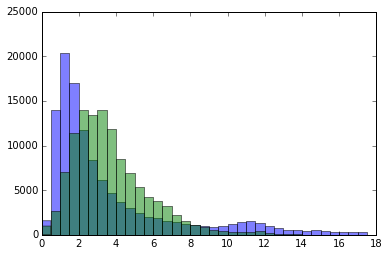

In [92]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5),alpha=0.5)
test_data_predict = LR_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5), alpha=0.5)

In [97]:
graphlab.evaluation.rmse(test_data['ADLOADINGTIME'],LR_model.predict(test_data))

3.264962651196299

##Evaluation using Random Forests

In [76]:
train_data,test_data = data.random_split(.5,seed=1)
RF_model = graphlab.random_forest_regression.create(train_data, target='ADLOADINGTIME',validation_set=test_data,
                                           max_iterations=20,
                                           max_depth =  50, row_subsample=0.5, random_seed=1)

Random forest regression:

--------------------------------------------------------

Number of examples          : 116524

Number of features          : 18

Number of unpacked features : 18

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 2.024115     | 18.050499          | 2.984370      | 17.864000            | 3.660505        |

| 2         | 4.062232     | 17.544041          | 2.728257      | 17.431168            | 3.344073        |

| 3         | 6.206354     | 16.821718          | 2.624283      | 17.334629            | 3.271723        |

| 4         | 8.436482     | 16.747705          | 2.562940      | 17.377522            | 3.232578        |

| 5         | 10.528602    | 16.165871          | 2.521587      | 17.412485            | 3.203516        |

| 6         | 12.298703    | 16.107243          | 2.520899      | 17.446987            | 3.176994        |

| 7         | 13.902795    | 16.029106          | 2.516299      | 17.319523            | 3.154830        |

| 8         | 15.577891    | 16.016144          | 2.525620      | 17.297915            | 3.136409        |

| 9         | 17.379994    | 15.995747          | 2.523729      | 17.326981            | 3.128539        |

| 10        | 19.263101    | 15.983532          | 2.524037      | 17.165012            | 3.119895        |

| 11        | 21.347221    | 15.967791          | 2.511598      | 17.094858            | 3.117127        |

| 12        | 23.389337    | 15.952959          | 2.502755      | 17.109900            | 3.113328        |

| 13        | 25.505458    | 15.489704          | 2.491688      | 17.087881            | 3.112940        |

| 14        | 27.547575    | 15.573284          | 2.486071      | 17.125868            | 3.109752        |

| 15        | 29.533689    | 15.645179          | 2.486375      | 17.069408            | 3.106882        |

| 16        | 31.627809    | 15.715332          | 2.478487      | 17.077145            | 3.105818        |

| 17        | 33.389909    | 15.778450          | 2.479375      | 17.014574            | 3.102640        |

| 18        | 35.678040    | 15.525890          | 2.471962      | 17.038368            | 3.102150        |

| 19        | 37.590150    | 15.542549          | 2.473297      | 17.064928            | 3.100149        |

| 20        | 39.772274    | 15.564790          | 2.469768      | 17.044918            | 3.100383        |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

(array([  0.00000000e+00,   1.74300000e+03,   7.94200000e+03,
          1.91350000e+04,   2.00480000e+04,   1.50370000e+04,
          1.05520000e+04,   7.90500000e+03,   6.22700000e+03,
          4.92500000e+03,   4.16700000e+03,   3.48500000e+03,
          3.01100000e+03,   2.53500000e+03,   2.40200000e+03,
          1.93100000e+03,   1.27700000e+03,   9.29000000e+02,
          7.02000000e+02,   5.92000000e+02,   4.91000000e+02,
          5.24000000e+02,   4.48000000e+02,   5.34000000e+02,
          3.50000000e+01,   7.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

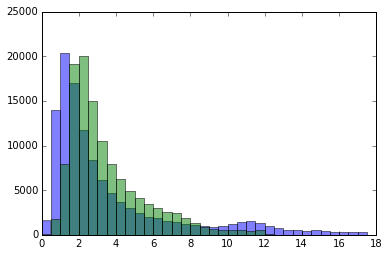

In [75]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5),alpha=0.5)
test_data_predict = RF_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5), alpha=0.5)

(array([  0.00000000e+00,   4.06000000e+02,   3.56300000e+03,
          1.53920000e+04,   2.01900000e+04,   1.80360000e+04,
          1.26090000e+04,   8.98800000e+03,   6.67200000e+03,
          5.46400000e+03,   4.54000000e+03,   3.95500000e+03,
          3.23800000e+03,   2.89000000e+03,   2.59000000e+03,
          2.14200000e+03,   1.42100000e+03,   1.01800000e+03,
          6.89000000e+02,   5.88000000e+02,   6.07000000e+02,
          5.46000000e+02,   5.48000000e+02,   4.14000000e+02,
          7.30000000e+01,   5.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

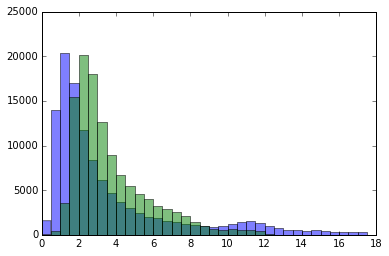

In [86]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5),alpha=0.5)
test_data_predict = RF_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5), alpha=0.5)

(array([  2.30000000e+01,   2.08900000e+03,   1.05770000e+04,
          1.96690000e+04,   1.79310000e+04,   1.42010000e+04,
          1.08200000e+04,   8.29600000e+03,   6.12700000e+03,
          4.90000000e+03,   4.02800000e+03,   3.42000000e+03,
          2.84000000e+03,   2.30500000e+03,   1.82400000e+03,
          1.52000000e+03,   1.12500000e+03,   8.07000000e+02,
          6.61000000e+02,   5.84000000e+02,   5.52000000e+02,
          4.79000000e+02,   2.29000000e+02,   2.76000000e+02,
          3.20000000e+01,   8.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  1

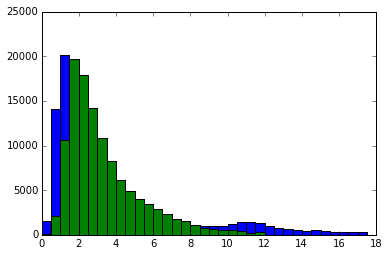

In [33]:
plt.hist(test_data['ADLOADINGTIME'],  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5))
test_data_predict = RF_model.predict(test_data)
plt.hist(test_data_predict,  bins=np.arange(0, int(max(test_data['ADLOADINGTIME'])),0.5))

In [251]:
data.num_rows()

233108

In [47]:
data.print_rows(5,
               50)

+---------------+-------------------------------+------------+----------+-----------------+
| ADLOADINGTIME |          PLACEMENTID          | TIMESTAMP  | PLATFORM | PLATFORMVERSION |
+---------------+-------------------------------+------------+----------+-----------------+
|     7.121     | f6297752e6cd8cd455c55d95c0... | 1459512400 | Android  |       4.3       |
|     1.616     | 7b76845786cdb6773e1d0024e9... | 1459513778 |   IOS    |       9.3       |
|     0.947     | 36793d8fe98b79d0e6bd1ecee0... | 1459513057 |   IOS    |      9.2.1      |
|     6.978     | 04a34aa00b34c0a400427aad3b... | 1459513155 |   IOS    |      9.2.1      |
|     2.713     | 7e44ca19e19fd7995312204a89... | 1459514610 |   IOS    |      9.2.1      |
+---------------+-------------------------------+------------+----------+-----------------+
+--------------------+------------------+---------+--------------+-----------+
| INTENDEDDEVICETYPE | ACTUALDEVICETYPE | CDNNAME | CREATIVETYPE | GEOIP_LNG |
+-------------

In [54]:
sales['ADLOADINGTIME'] = sales['ADLOADINGTIME'].apply(lambda x: 100.0 if x>=100 else x)

Less than 8 successfully started. Using only 7 workers.

All operations will proceed as normal, but lambda operations will not be able to use all available cores.

To help us diagnose this issue, please send the log file to product-feedback@dato.com.

(The location of the log file is printed at the start of the GraphLab server).

In [152]:
sales = sales[sales['ADLOADINGTIME']<10]

In [13]:
sales['ADLOADINGTIME'].mean()

11.10010042857145

In [42]:
sales['ADLOADINGTIME'].show()

Canvas is accessible via web browser at the URL: http://localhost:16269/index.html
Opening Canvas in default web browser.


In [71]:
sales['TMP'] = sales['PLATFORM'] + sales['ACTUALDEVICETYPE'] + sales['UA_HARDWARETYPE']

In [3]:
sales = graphlab.SFrame.read_csv('E:\celtraMiningFrik\ccdm_medium.tsv','\t',column_type_hints=str)

2016-05-11 16:12:42,658 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: C:\Users\Tim\AppData\Local\Temp\graphlab_server_1462975956.log.0


Finished parsing file E:\celtraMiningFrik\ccdm_medium.tsv

Parsing completed. Parsed 49000 lines in 1.46608 secs.

This non-commercial license of GraphLab Create is assigned to tim.jerman@gmail.com and will expire on December 31, 2016. For commercial licensing options, visit https://dato.com/buy/.


In [153]:
train_data,test_data = sales.random_split(.8,seed=0)

In [155]:
sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['ERRORSJSON'],validation_set=test_data, max_iterations=20)

Linear regression:

--------------------------------------------------------

Number of examples          : 32384

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 12

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.076004     | 7.341860           | 7.330860             | 2.118432      | 2.117206        |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [93]:
model = graphlab.random_forest_regression.create(train_data, target='ADLOADINGTIME',features=['FILESJSON'],
                                           max_iterations=50,
                                           max_depth =  20, validation_set=test_data)

Random forest regression:

--------------------------------------------------------

Number of examples          : 39240

Number of features          : 1

Number of unpacked features : 1

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 0.039003     | 1652.351196        | 57.381062     | 1754.352173          | 58.306862       |

| 2         | 0.074005     | 1654.799072        | 57.293003     | 1754.433594          | 58.260490       |

| 3         | 0.110007     | 1655.225464        | 57.253265     | 1757.442627          | 58.262161       |

| 4         | 0.144009     | 1654.682007        | 57.228996     | 1762.991577          | 58.282616       |

| 5         | 0.178010     | 1653.610352        | 57.225727     | 1761.320923          | 58.265350       |

| 6         | 0.212012     | 1654.596069        | 57.223824     | 1759.972412          | 58.267365       |

| 11        | 0.375022     | 1655.760376        | 57.222836     | 1764.235352          | 58.219090       |

| 50        | 1.670096     | 1670.888184        | 57.286541     | 1761.458862          | 58.056999       |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

In [21]:
from graphlab.toolkits.feature_engineering import OneHotEncoder
encoder = graphlab.feature_engineering.create(graphlab.SFrame(sales['PLATFORM']), OneHotEncoder())

# Transform the data.
transformed_sf = encoder.transform(graphlab.SFrame(sales['PLATFORM']))

In [42]:
from graphlab.toolkits.feature_engineering import OneHotEncoder
encoder = graphlab.feature_engineering.create(sales, OneHotEncoder())

# Transform the data.
transformed_sf = encoder.transform(sales)
print(transformed_sf['encoded_features'][0])

WARNING: Column 'ADLOADINGTIME' is excluded due to invalid column type (float).

{45568L: 1L, 46081L: 1L, 78123L: 1L, 78341L: 1L, 41608L: 1L, 80428L: 1L, 48267L: 1L, 1037L: 1L, 79762L: 1L, 48275L: 1L, 48276L: 1L, 48279L: 1L, 78105L: 1L, 41626L: 1L, 48284L: 1L, 80416L: 1L, 33L: 1L, 78116L: 1L, 78118L: 1L, 79401L: 1L, 44715L: 1L, 43436L: 1L, 44718L: 1L, 80048L: 1L, 79624L: 1L, 44722L: 1L, 41523L: 1L, 44725L: 1L, 71096L: 1L, 17467L: 1L, 80060L: 1L, 70974L: 1L, 78112L: 1L, 78192L: 1L, 453L: 1L, 77895L: 1L, 79735L: 1L, 60883L: 1L, 71256L: 1L, 44634L: 1L, 49895L: 1L, 240L: 1L, 47220L: 1L, 77685L: 1L, 72695L: 1L, 41593L: 1L}


In [43]:
encoder['feature_encoding']

feature,category,index
ACCOUNTID,4af2e544b33d2f2a60219b42bf0be05a ...,0
ACCOUNTID,550d00d2e3051031abb49918b3bb9769 ...,1
ACCOUNTID,03b94b2bbe323d35cdc4db2551e4186c ...,2
ACCOUNTID,cf6396ab0434e6dc22b2622c2ac1c1dd ...,3
ACCOUNTID,4eed823fccaed126bc0c314cbe4e1278 ...,4
ACCOUNTID,ada9c7b769af3fe3e7ce3a7bc0a5b32c ...,5
ACCOUNTID,f70c8546e1b0df1eb32847f4271007d5 ...,6
ACCOUNTID,b589d9db9c479ad8838666813a5d7fe0 ...,7
ACCOUNTID,fd3f7585fa0a42203cefbdf5d90fddeb ...,8
ACCOUNTID,750c1ddb2d92618e03a04eadbeacb42b ...,9


In [107]:
print sqft_model.evaluate(test_data)

{'max_error': 1774.4952348506465, 'rmse': 60.28488671480435}


In [54]:
print sqft_model.predict(test_data[0])
test_data[0]

[109.11121597655671]


{'ACCOUNTID': '707cd8f4c88718677e1b9eeecd01160d',
 'ACTUALDEVICETYPE': 'null',
 'ADLOADINGTIME': 2.645,
 'CAMPAIGNID': 'ef070bfa66a86845986ebbb82770ecb3',
 'CDNNAME': 'a',
 'CREATIVEID': 'a5756b4875e7c994ec5b2a301c12e766',
 'CREATIVETYPE': 'Interstitial',
 'DEVICEORIENTATION': '90',
 'ERRORSJSON': '[]',
 'EXTERNALADSERVER': '598f379729bb422dda38111dcbb00ba5',
 'EXTERNALCREATIVEID': 'null',
 'EXTERNALPLACEMENTID': 'null',
 'EXTERNALSITEID': '375bc670eef7620bda2f75a9086b1561',
 'EXTERNALSUPPLIERID': 'null',
 'FILESJSON': '[{"type":"image","size":37726},{"type":"image","size":9114},{"type":"image","size":3969},{"type":"image","size":6117}]',
 'GEOIP_AREACODE': 'null',
 'GEOIP_CITY': 'Redkino',
 'GEOIP_COUNTRY': 'Russian Federation',
 'GEOIP_DMACODE': 'null',
 'GEOIP_LAT': '56.6333',
 'GEOIP_LNG': '36.28329',
 'GEOIP_METROCODE': 'null',
 'GEOIP_REGION': "Tver'",
 'GEOIP_TIMEZONE': 'Europe/Moscow',
 'HOSTWINDOWHEIGHT': '720',
 'HOSTWINDOWWIDTH': '1280',
 'INTENDEDDEVICETYPE': 'Phone',
 'NET

In [46]:
model = graphlab.random_forest_regression.create(train_data, target='ADLOADINGTIME',
                                           num_trees=25,
                                           max_depth =  20, row_subsample=0.5)

2016-05-06 22:23:02,219 [WARNING] graphlab.toolkits.regression.random_forest_regression, 477: The `num_trees` keyword argument is deprecated. Please use the `max_iterations` argument instead. Any value provided for `num_trees` will be used in place of `max_iterations`.


WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

WARNING: Detected extremely low variance for feature(s) 'EXTERNALCREATIVEID', 'NETWORKTYPE' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Random forest regression:

--------------------------------------------------------

Number of examples          : 37143

Number of features          : 46

Number of unpacked features : 46

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 0.207012     | 1652.029175        | 46.287724     | 1080.888184          | 45.582462       |

| 2         | 0.376022     | 1652.320801        | 45.326775     | 1081.179810          | 46.251766       |

| 3         | 0.530031     | 1652.266968        | 45.331711     | 1081.125977          | 46.411507       |

| 4         | 0.692040     | 1446.483521        | 44.515816     | 1081.119995          | 46.639938       |

| 5         | 0.847049     | 1487.674194        | 44.203506     | 1081.155273          | 46.624088       |

| 6         | 0.995057     | 1377.917358        | 44.010422     | 1081.190308          | 46.412617       |

| 10        | 1.671096     | 1326.853027        | 43.726196     | 1081.252075          | 46.499245       |

| 11        | 1.824105     | 1302.039551        | 43.759861     | 1081.262329          | 46.635567       |

| 20        | 3.251186     | 1281.971191        | 43.692116     | 1081.228760          | 46.197197       |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



In [109]:
graphlab.evaluation.rmse(sales['ADLOADINGTIME'], graphlab.SArray.from_const(100,len(sales['ADLOADINGTIME'])))

107.72669630327103

In [121]:
sales['ADLOADINGTIME'][0:10]

dtype: float
Rows: 10
[21.73, 2.753, 12.962, 7.121, 4.301, 11.175, 9.833, 2.614, 2.61, 58.08]

In [139]:
graphlab.evaluation.rmse(sales['ADLOADINGTIME'][0:10], graphlab.SArray.from_const(10,10))

16.31536884351684

In [122]:
sales['ADLOADINGTIME'][0:10].mean()

13.317900000000002

In [137]:
((sales['ADLOADINGTIME'][0:10]-10)*(sales['ADLOADINGTIME'][0:10]-1)).sum()

2960.523605

(array([ 313905.,  737799.,  404030.,  212633.,  132650.,   91897.,
          68089.,   52749.,   42156.,   38018.,   51504.,   55204.,
          35383.,   23996.,   18899.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

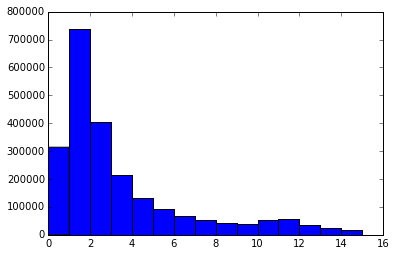

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
tmp = sales[sales['ADLOADINGTIME']<np.percentile(sales['ADLOADINGTIME'],94)]
plt.hist(tmp['ADLOADINGTIME'],  bins=range(0, int(max(tmp['ADLOADINGTIME']))))

In [15]:
# 3.7835
perct = 97
print(np.percentile(sales['ADLOADINGTIME'],perct))
salesCut = sales[sales['ADLOADINGTIME']<np.percentile(sales['ADLOADINGTIME'],perct)]
print(graphlab.evaluation.rmse(salesCut['ADLOADINGTIME'], graphlab.SArray.from_const(salesCut['ADLOADINGTIME'].mean()*0.95,len(salesCut['ADLOADINGTIME']))))
print(graphlab.evaluation.rmse(salesCut['ADLOADINGTIME'], graphlab.SArray.from_const(salesCut['ADLOADINGTIME'].mean(),len(salesCut['ADLOADINGTIME']))))
print(graphlab.evaluation.rmse(salesCut['ADLOADINGTIME'], graphlab.SArray.from_const(salesCut['ADLOADINGTIME'].mean()*1.05,len(salesCut['ADLOADINGTIME']))))
print(graphlab.evaluation.rmse(salesCut['ADLOADINGTIME'], graphlab.SArray.from_const(np.median(salesCut['ADLOADINGTIME'])*0.95,len(salesCut['ADLOADINGTIME']))))
print(graphlab.evaluation.rmse(salesCut['ADLOADINGTIME'], graphlab.SArray.from_const(np.median(salesCut['ADLOADINGTIME']),len(salesCut['ADLOADINGTIME']))))
print(graphlab.evaluation.rmse(salesCut['ADLOADINGTIME'], graphlab.SArray.from_const(np.median(salesCut['ADLOADINGTIME'])*1.5,len(salesCut['ADLOADINGTIME']))))

29.229
4.6256816292
4.62103835673
4.6256816292
5.03263921495
4.98888527226
4.68121037545


In [79]:
salesCut.show()

Canvas is accessible via web browser at the URL: http://localhost:59632/index.html
Opening Canvas in default web browser.


In [99]:
salesCut['ADLOADINGTIME'].mean()

3.745005617615481

In [84]:
test_data[0]

{'ACCOUNTID': 'a0776e9e61f79615d93907ec5710c9fa',
 'ACTUALDEVICETYPE': 'Phone',
 'ADLOADINGTIME': 2.753,
 'CAMPAIGNID': 'ab0a0251add6aba71e800537c6a729c8',
 'CDNNAME': 'c',
 'CREATIVEID': '83361d7aa1757e5f8e9ed97b71a8c49b',
 'CREATIVETYPE': 'Interstitial',
 'DEVICEORIENTATION': '0',
 'ERRORSJSON': '[]',
 'EXTERNALADSERVER': 'b46e86833f3f102dfeca4b7a13d6db21',
 'EXTERNALCREATIVEID': 'null',
 'EXTERNALPLACEMENTID': 'null',
 'EXTERNALSITEID': 'null',
 'EXTERNALSUPPLIERID': 'null',
 'FILESJSON': '[]',
 'GEOIP_AREACODE': 'null',
 'GEOIP_CITY': 'null',
 'GEOIP_COUNTRY': 'Tunisia',
 'GEOIP_DMACODE': 'null',
 'GEOIP_LAT': 34.0,
 'GEOIP_LNG': 9.0,
 'GEOIP_METROCODE': 'null',
 'GEOIP_REGION': 'null',
 'GEOIP_TIMEZONE': 'Africa/Tunis',
 'HOSTWINDOWHEIGHT': 615L,
 'HOSTWINDOWWIDTH': 360L,
 'INTENDEDDEVICETYPE': 'Phone',
 'NETWORKTYPE': 'null',
 'PLACEMENTID': 'f6297752e6cd8cd455c55d95c085035d',
 'PLATFORM': 'Android',
 'PLATFORMVERSION': '4.3',
 'SDK': '6650fadcc0264109f8bd976558377652',
 'TIMESTA

In [16]:
train_data,test_data = salesCut.random_split(.5,seed=1)

In [17]:
sqft_model = graphlab.linear_regression.create(train_data, target='ADLOADINGTIME',features=['CREATIVEID'],validation_set=test_data, max_iterations=20)

Linear regression:

--------------------------------------------------------

Number of examples          : 1187290

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 669

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 5        | 0.000000  | 0.805046     | 26.302009          | 26.178604            | 4.417042      | 4.415949        |

| 2         | 7        | 1.000000  | 1.478084     | 26.913171          | 26.785784            | 4.362262      | 4.363058        |

| 3         | 8        | 1.000000  | 1.971112     | 27.672285          | 27.541400            | 4.348217      | 4.350837        |

| 4         | 9        | 1.000000  | 2.531144     | 27.532657          | 27.401702            | 4.347165      | 4.349867        |

| 5         | 10       | 1.000000  | 3.068175     | 27.559506          | 27.428660            | 4.346897      | 4.349525        |

| 6         | 11       | 1.000000  | 3.582205     | 27.551761          | 27.420965            | 4.346889      | 4.349489        |

| 10        | 15       | 1.000000  | 5.724327     | 27.544505          | 27.413765            | 4.346879      | 4.349446        |

| 11        | 16       | 1.000000  | 6.226356     | 27.544581          | 27.413821            | 4.346870      | 4.349447        |

| 15        | 20       | 1.000000  | 8.303475     | 27.544545          | 27.413786            | 4.346870      | 4.349446        |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [18]:
sqft_model = graphlab.linear_regression.create(salesCut, target='ADLOADINGTIME',features=['CREATIVEID'],validation_set=test_data, max_iterations=20)

Linear regression:

--------------------------------------------------------

Number of examples          : 2376497

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 672

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 5        | 0.000000  | 1.471084     | 26.286789          | 26.163452            | 4.416559      | 4.415305        |

| 2         | 7        | 1.000000  | 2.676153     | 26.906066          | 26.778828            | 4.362718      | 4.362012        |

| 3         | 8        | 1.000000  | 3.540202     | 27.646225          | 27.515573            | 4.348556      | 4.348419        |

| 4         | 9        | 1.000000  | 4.390251     | 27.522189          | 27.391435            | 4.347731      | 4.347634        |

| 5         | 10       | 1.000000  | 5.250300     | 27.548523          | 27.417879            | 4.347470      | 4.347346        |

| 6         | 11       | 1.000000  | 6.050346     | 27.541595          | 27.410993            | 4.347464      | 4.347332        |

| 10        | 15       | 1.000000  | 9.454540     | 27.531578          | 27.401042            | 4.347452      | 4.347306        |

| 11        | 16       | 1.000000  | 10.335591    | 27.536123          | 27.405546            | 4.347444      | 4.347304        |

| 15        | 20       | 1.000000  | 13.927796    | 27.535317          | 27.404747            | 4.347444      | 4.347303        |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [19]:
sqft_model.save('E:\celtraMiningFrik\lin_reg_creativeid_perct_97')

In [ ]:
sqft_model = graphlab.load_model('E:\celtraMiningFrik\lin_reg_creativeid_perct_96')

In [105]:
print(graphlab.evaluation.rmse(test_data['ADLOADINGTIME'], graphlab.SArray.from_const(3.90365759806,len(test_data['ADLOADINGTIME']))))

3.72755946569


In [102]:
train_data.show()

Canvas is accessible via web browser at the URL: http://localhost:59632/index.html
Opening Canvas in default web browser.


In [ ]:
predTimes = sqft_model.predict(sales)

In [ ]:
predTimes.save('E:\celtraMiningFrik\solution4.tsv', format='csv')